# Laboratorio #4 - Familias de Malware

# Parte 1

In [1]:
import os
import pefile
import pandas as pd
import hashlib
import re
from datetime import datetime, timezone
import subprocess

## Creación del dataset

In [2]:
MALWARE_DIR = "./MALWR"
malware_files = [os.path.join(MALWARE_DIR, f) for f in os.listdir(MALWARE_DIR) if os.path.isfile(os.path.join(MALWARE_DIR, f))]

print(f"🔍 Se encontraron {len(malware_files)} archivos de malware en el directorio.")

🔍 Se encontraron 40 archivos de malware en el directorio.


In [3]:
# 📌 Función para calcular SHA-256
def get_sha256(file_path):
    sha256_hash = hashlib.sha256()
    with open(file_path, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()

# 📌 Función para extraer timestamps
def convert_timestamp(timestamp):
    try:
        return datetime.fromtimestamp(timestamp, timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    except (OSError, OverflowError, ValueError):
        return "Invalid Timestamp"

# 📌 API sospechosas
suspicious_api_calls = {
    "process hollowing": {
        "CreateProcess", "GetModuleHandle", "GetProcAddress", "VirtualAllocEx", "WriteProcessMemory", "SetThreadContext", "ResumeThread"
    },
    "create remote thread": {
        "OpenProcess", "GetModuleHandle", "GetProcAddress", "VirtualAllocEx", "WriteProcessMemory", "CreateRemoteThread"
    },
    "enumerating processes": {
        "CreateToolhelp32Snapshot", "Process32First", "Process32Next", "WTSEnumerateProcesses"
    },
    "drop file from PE resource": {
        "GetModuleHandle", "FindResource", "LoadResource", "CreateFileA"
    },
    "IAT hooking": {
        "GetModuleHandle", "strcmp", "VirtualProtect"
    },
    "delete itself": {
        "GetModuleFileName", "ExitProcess", "DeleteFile"
    },
    "download and execute PE file": {
        "URLDownloadToFile", "ShellExecute"
    },
    "bind TCP port": {
        "WSAStartup", "socket"
    },
    "capture network traffic": {
        "socket", "bind", "WSAIoctl", "recvfrom"
    }
}

# 📌 Función para extraer importaciones
def extract_imports(pe):
    imported_functions = []
    imported_dlls = []
    detected_suspicious_apis = set()

    if hasattr(pe, "DIRECTORY_ENTRY_IMPORT"):
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            dll_name = entry.dll.decode(errors="ignore")
            imported_dlls.append(dll_name)

            for function in entry.imports:
                func_name = function.name.decode(errors="ignore") if function.name else "N/A"
                imported_functions.append(func_name)

                for category, apis in suspicious_api_calls.items():
                    if func_name in apis:
                        detected_suspicious_apis.add(func_name)

    return {
        "DLLs": imported_dlls,
        "Functions": imported_functions,
        "SuspiciousAPIs": list(detected_suspicious_apis)
    }

# 📌 Función para extraer strings sospechosas
def extract_strings(file_path):
    with open(file_path, "rb") as f:
        data = f.read()

    strings = re.findall(b"[ -~]{4,}", data)
    decoded_strings = [s.decode("utf-8", "ignore") for s in strings]

    suspicious_keywords = ["http", "ftp", "cmd", "powershell", "wget", "curl", "0.0.0.0"]
    suspicious_count = sum(1 for s in decoded_strings if any(k in s for k in suspicious_keywords))

    return suspicious_count

def detect_packing_by_size(sections):
    packed_sections = 0
    for section in sections:
        raw_size = section["RawSize"]
        virtual_size = section["VirtualSize"]

        # 📌 Un ejecutable empaquetado suele tener secciones con RawSize muy pequeño y VirtualSize grande
        if raw_size > 0 and virtual_size / raw_size > 10:  # Umbral ajustable
            packed_sections += 1

    return 1 if packed_sections > 0 else 0

In [4]:
def extract_pe_info(file_path):
    try:
        pe = pefile.PE(file_path)
        imports_data = extract_imports(pe)

        # 📌 Evaluar secciones del ejecutable
        section_data = []
        for section in pe.sections:
            section_data.append({
                "Name": section.Name.rstrip(b'\x00').decode(errors="ignore"),
                "RawSize": section.SizeOfRawData,
                "VirtualSize": section.Misc_VirtualSize
            })
        

        pe_info = {
            "Filename": os.path.basename(file_path),
            "SHA256": get_sha256(file_path),
            "TimeDateStamp": convert_timestamp(pe.FILE_HEADER.TimeDateStamp),
            "Subsystem": pe.OPTIONAL_HEADER.Subsystem,
            "NumberOfSections": pe.FILE_HEADER.NumberOfSections,
            "Num_DLLs": len(imports_data["DLLs"]),
            "Num_Imports": len(imports_data["Functions"]),
            "Num_Suspicious_APIs": len(imports_data["SuspiciousAPIs"]),
            "Strings": extract_strings(file_path),
            "Packed_By_Size": detect_packing_by_size(section_data)  # 📌 Nueva evaluación
        }

        pe.close()
        return pe_info

    except Exception as e:
        print(f"⚠️ Error analizando {file_path}: {e}")
        return None

In [5]:
dataset = []
for file in malware_files:
    if not os.path.isfile(file):
        continue
    pe_data = extract_pe_info(file)
    if pe_data:
        dataset.append(pe_data)

df = pd.DataFrame(dataset)

# 📌 Guardar dataset limpio
df.to_csv("malware_dataset_optimized.csv", index=False)
print("✅ Dataset optimizado guardado como 'malware_dataset_optimized.csv'")

# 📌 Mostrar las primeras filas
display(df.head())

✅ Dataset optimizado guardado como 'malware_dataset_optimized.csv'


,Filename,SHA256,TimeDateStamp,Subsystem,NumberOfSections,Num_DLLs,Num_Imports,Num_Suspicious_APIs,Strings,Packed_By_Size
0,JH78C0A33A1B472A8C16123FD696A5CE5EBB,14af57c8a6a37b2fa9bd738285b2951b63fcfb34e1450c...,2009-05-14 17:12:40,2,4,5,62,2,4,0
1,NBV_8B75BCBFF174C25A0161F30758509A44,f52af02529b12c20e45618cae1a38c4ace06f5496ce160...,2009-05-14 17:12:40,2,4,5,62,2,4,0
2,POL55_A4F1ECC4D25B33395196B5D51A06790,57ef37c30a4a10b334a745d2f6235b4703ae99cf8e64e1...,2011-07-29 07:10:31,2,3,7,85,3,5,1
3,6FAA4740F99408D4D2DDDD0B09BBDEFD,a5244829aa94b009e479f06f7ae3e9f40daef32b1570c4...,2009-05-14 17:12:40,2,4,5,62,2,4,0
4,A316D5AECA269CA865077E7FFF356E7D,02e0d550c86910a19ab73ec02bcbe4ed095d683414db2f...,2009-05-14 17:12:40,2,4,5,62,2,4,0


## Exploración y pre-procesamiento de datos

In [6]:
df = pd.read_csv("malware_dataset_optimized.csv")

In [7]:
# Mostrar las primeras filas
display(df.head())

# Revisar los tipos de datos
print("\n📌 Tipos de datos en cada columna:")
print(df.dtypes)

# Revisar valores nulos
print("\n📌 Valores nulos en el dataset:")
print(df.isnull().sum())

# Revisar estadísticas de columnas numéricas
print("\n📌 Resumen estadístico de columnas numéricas:")
print(df.describe())

# Revisar estadísticas de columnas categóricas
print("\n📌 Resumen estadístico de columnas categóricas:")
print(df.describe(include="object"))

,Filename,SHA256,TimeDateStamp,Subsystem,NumberOfSections,Num_DLLs,Num_Imports,Num_Suspicious_APIs,Strings,Packed_By_Size
0,JH78C0A33A1B472A8C16123FD696A5CE5EBB,14af57c8a6a37b2fa9bd738285b2951b63fcfb34e1450c...,2009-05-14 17:12:40,2,4,5,62,2,4,0
1,NBV_8B75BCBFF174C25A0161F30758509A44,f52af02529b12c20e45618cae1a38c4ace06f5496ce160...,2009-05-14 17:12:40,2,4,5,62,2,4,0
2,POL55_A4F1ECC4D25B33395196B5D51A06790,57ef37c30a4a10b334a745d2f6235b4703ae99cf8e64e1...,2011-07-29 07:10:31,2,3,7,85,3,5,1
3,6FAA4740F99408D4D2DDDD0B09BBDEFD,a5244829aa94b009e479f06f7ae3e9f40daef32b1570c4...,2009-05-14 17:12:40,2,4,5,62,2,4,0
4,A316D5AECA269CA865077E7FFF356E7D,02e0d550c86910a19ab73ec02bcbe4ed095d683414db2f...,2009-05-14 17:12:40,2,4,5,62,2,4,0



📌 Tipos de datos en cada columna:
Filename               object
SHA256                 object
TimeDateStamp          object
Subsystem               int64
NumberOfSections        int64
Num_DLLs                int64
Num_Imports             int64
Num_Suspicious_APIs     int64
Strings                 int64
Packed_By_Size          int64
dtype: object

📌 Valores nulos en el dataset:
Filename               0
SHA256                 0
TimeDateStamp          0
Subsystem              0
NumberOfSections       0
Num_DLLs               0
Num_Imports            0
Num_Suspicious_APIs    0
Strings                0
Packed_By_Size         0
dtype: int64

📌 Resumen estadístico de columnas numéricas:
       Subsystem  NumberOfSections   Num_DLLs  Num_Imports  \
count       40.0         40.000000  40.000000    40.000000   
mean         2.0          3.800000   5.875000   103.175000   
std          0.0          0.516398   1.522271    73.654038   
min          2.0          3.000000   4.000000    51.000000   


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ["NumberOfSections", "Num_DLLs", "Num_Imports", "Num_Suspicious_APIs", "Strings"]

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print("✅ Columnas numéricas normalizadas correctamente")

✅ Columnas numéricas normalizadas correctamente


In [9]:
df = pd.get_dummies(df, columns=["Subsystem"], prefix="Subsystem")

In [10]:
# Filtrar solo columnas numéricas antes de calcular la correlación
df_numeric = df.select_dtypes(include=['number'])

# Verificar qué columnas quedaron después del filtrado
print("📊 Columnas numéricas en el DataFrame:")
print(df_numeric.columns)

📊 Columnas numéricas en el DataFrame:
Index(['NumberOfSections', 'Num_DLLs', 'Num_Imports', 'Num_Suspicious_APIs',
       'Strings', 'Packed_By_Size'],
      dtype='object')


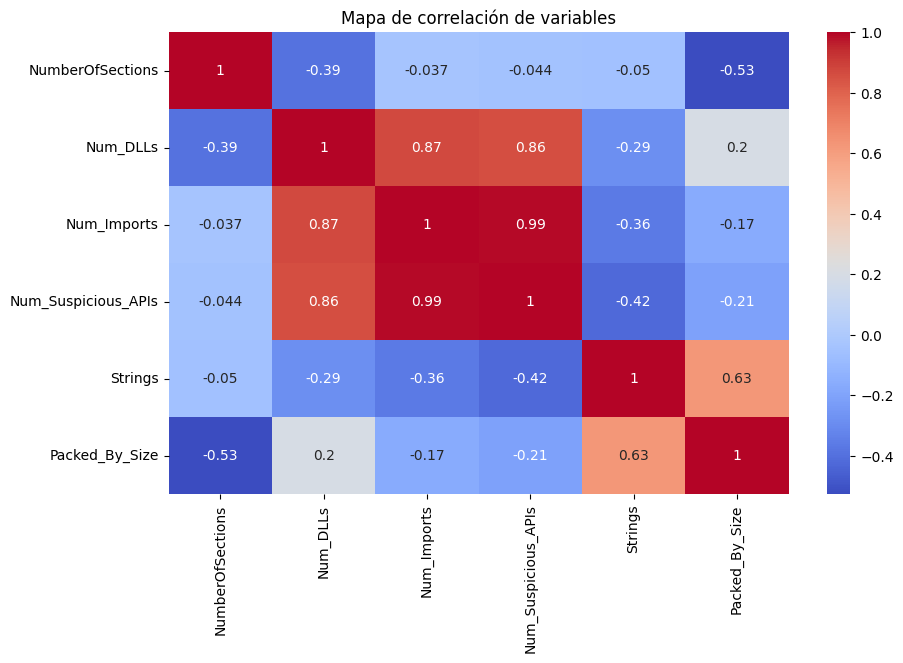

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm")
plt.title("Mapa de correlación de variables")
plt.show()

# Parte 2

## Implementación del modelo

### Algoritmo 1

/Users/mvrcentes/Library/CloudStorage/OneDrive-UVG/Documentos/Semestre_9/Security_Data_Science/Security_Data_Science/myvenv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


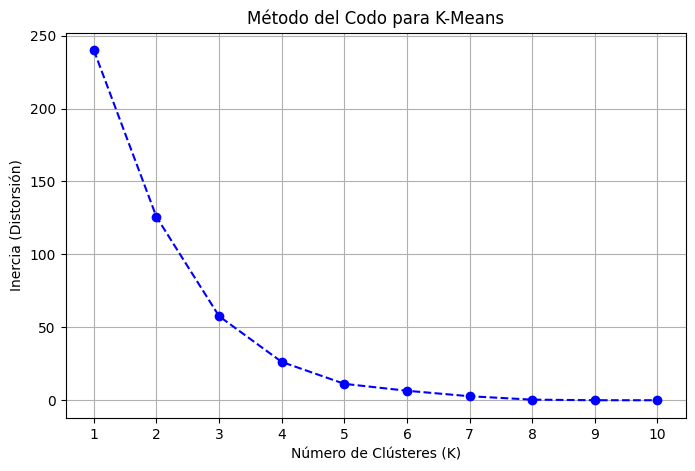

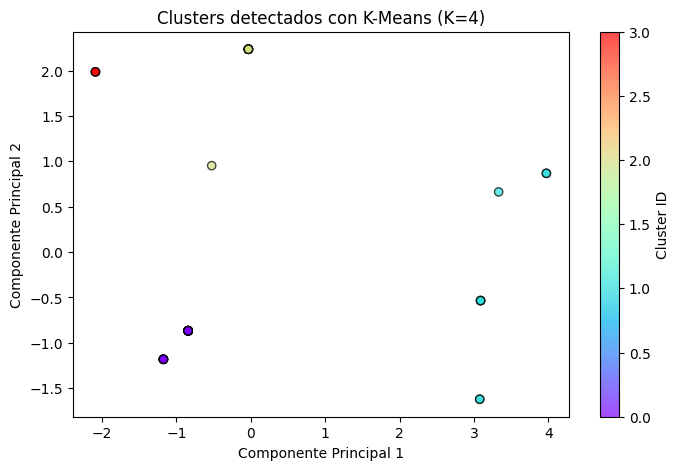

🔍 Número de clusters encontrados con DBSCAN: 5


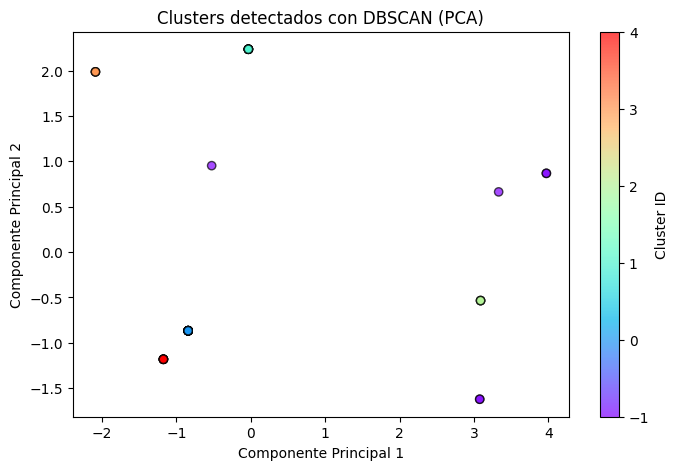

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# 📌 Cargar dataset
df = pd.read_csv("malware_dataset_optimized.csv")

# 📌 Filtrar solo columnas numéricas para clustering
df_numeric = df.select_dtypes(include=['number'])

# 📌 Escalar los datos para mejorar el rendimiento de los algoritmos de clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# 📌 Definir rango de valores de K para evaluar
K_range = range(1, 11)

# 📌 Almacenar las distorsiones (inercia) para K-Means
inertia = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# 📌 Gráfica del Método del Codo para K-Means
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
plt.xlabel("Número de Clústeres (K)")
plt.ylabel("Inercia (Distorsión)")
plt.title("Método del Codo para K-Means")
plt.xticks(K_range)
plt.grid(True)
plt.show()

# 📌 Aplicar reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# 📌 Aplicar K-Means con el número óptimo de clusters (supongamos K=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)

# 📌 Visualización de Clusters de K-Means con PCA
plt.figure(figsize=(8, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans_labels, cmap="rainbow", edgecolors="k", alpha=0.7)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title(f"Clusters detectados con K-Means (K={optimal_k})")
plt.colorbar(label="Cluster ID")
plt.show()

# 📌 Ajustar DBSCAN con valores más óptimos
dbscan = DBSCAN(eps=0.5, min_samples=3)  # Se puede ajustar eps y min_samples
dbscan_labels = dbscan.fit_predict(df_scaled)

# 📌 Contar número de clusters encontrados (ignorando ruido -1)
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"🔍 Número de clusters encontrados con DBSCAN: {num_clusters}")

# 📌 Visualización de Clusters de DBSCAN con PCA
plt.figure(figsize=(8, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=dbscan_labels, cmap="rainbow", edgecolors="k", alpha=0.7)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Clusters detectados con DBSCAN (PCA)")
plt.colorbar(label="Cluster ID")
plt.show()

Basándonos en las gráficas obtenidas del método del codo para K-Means, podemos notar que la inercia disminuye rápidamente hasta K=4 y luego la reducción es mucho más leve. Este es el punto donde se encuentra el “codo”, lo que indica que 4 es el número óptimo de clústeres según este método. En la visualización de K-Means con K=4, se observa una separación clara entre los grupos, lo que confirma que esta cantidad es adecuada para nuestra data.

Por otro lado, DBSCAN encontró 5 clústeres, lo que sugiere que algunos datos tienen una densidad diferente y podrían representar variaciones dentro de las familias de malware. Sin embargo, DBSCAN también detectó ruido (-1), lo que significa que algunos puntos no se agrupan bien en ningún clúster.

Aunque DBSCAN identifica más detalles en la estructura de los datos, la técnica de K-Means es más consistente en su agrupación. Por eso, elegimos K=4 como el número óptimo de clústeres, ya que es el punto donde logramos la mejor segmentación sin agrupar datos de forma forzada o generar demasiado ruido.

## Coeficiente de Silhouette

/Users/mvrcentes/Library/CloudStorage/OneDrive-UVG/Documentos/Semestre_9/Security_Data_Science/Security_Data_Science/myvenv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


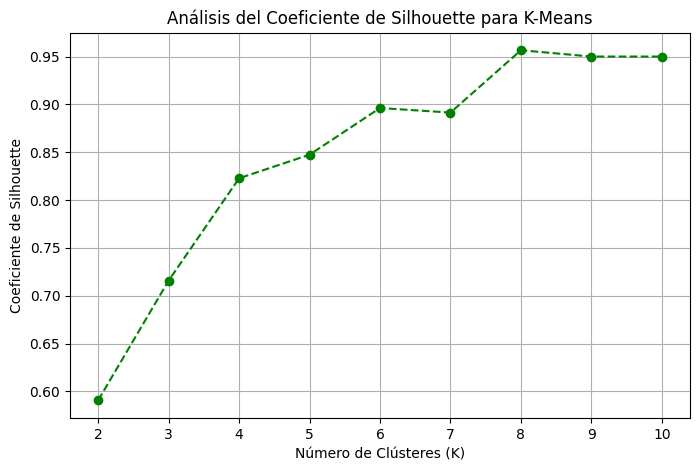

🔍 Mejor número de clústeres según Silhouette: 8


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# 📌 Cargar dataset
df = pd.read_csv("malware_dataset_optimized.csv")

# 📌 Filtrar solo columnas numéricas para clustering
df_numeric = df.select_dtypes(include=['number'])

# 📌 Escalar los datos para mejorar el rendimiento de los algoritmos de clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# 📌 Definir rango de valores de K para evaluar
K_range = range(2, 11)  # El coeficiente de Silhouette no se puede calcular para K=1

# 📌 Almacenar los valores del coeficiente de Silhouette
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)

# 📌 Gráfica del Coeficiente de Silhouette
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='g')
plt.xlabel("Número de Clústeres (K)")
plt.ylabel("Coeficiente de Silhouette")
plt.title("Análisis del Coeficiente de Silhouette para K-Means")
plt.xticks(K_range)
plt.grid(True)
plt.show()

# 📌 Determinar el mejor número de clústeres según el coeficiente de Silhouette
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
print(f"🔍 Mejor número de clústeres según Silhouette: {optimal_k_silhouette}")

## Gemini

In [28]:
import google.generativeai as genai
import pandas as pd
import numpy as np
from google.api_core import retry
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar Gemini API
genai.configure(api_key=os.getenv("GENAI_API_KEY"))

tqdm.pandas()  # Para ver el progreso en Pandas

# Función para generar embeddings con Gemini AI
def make_embed_text_fn(model):
    @retry.Retry(timeout=300.0)
    def embed_fn(text: str) -> list[float]:
        embedding = genai.embed_content(model=model, content=text, task_type="clustering")
        return embedding["embedding"]
    return embed_fn

# Cargar dataset
df = pd.read_csv("malware_dataset_optimized.csv")

# Convertir la columna de características en texto
df["Features"] = df["Num_Suspicious_APIs"].astype(str)

# Generar embeddings
model = "models/embedding-001"
df["Embeddings"] = df["Features"].progress_apply(make_embed_text_fn(model))

# Convertir a matriz NumPy
X = np.array(df["Embeddings"].to_list(), dtype=np.float32)

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Embeddings generados y normalizados correctamente.")

100%|██████████| 40/40 [00:08<00:00,  4.99it/s]

✅ Embeddings generados y normalizados correctamente.


In [29]:
# Aplicar K-Means con K=8 (según el coeficiente de Silhouette)
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Family"] = kmeans.fit_predict(X_scaled)

# Convertir las etiquetas en nombres de familia
df["Family"] = df["Family"].apply(lambda x: f"Fam{x}")

# Mostrar cuántos elementos hay en cada familia
print("📊 Distribución de malware por familia:")
print(df["Family"].value_counts())

📊 Distribución de malware por familia:
Family
Fam0    24
Fam1     8
Fam2     3
Fam3     3
Fam4     2
Name: count, dtype: int64


/Users/mvrcentes/Library/CloudStorage/OneDrive-UVG/Documentos/Semestre_9/Security_Data_Science/Security_Data_Science/myvenv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


/Users/mvrcentes/Library/CloudStorage/OneDrive-UVG/Documentos/Semestre_9/Security_Data_Science/Security_Data_Science/myvenv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


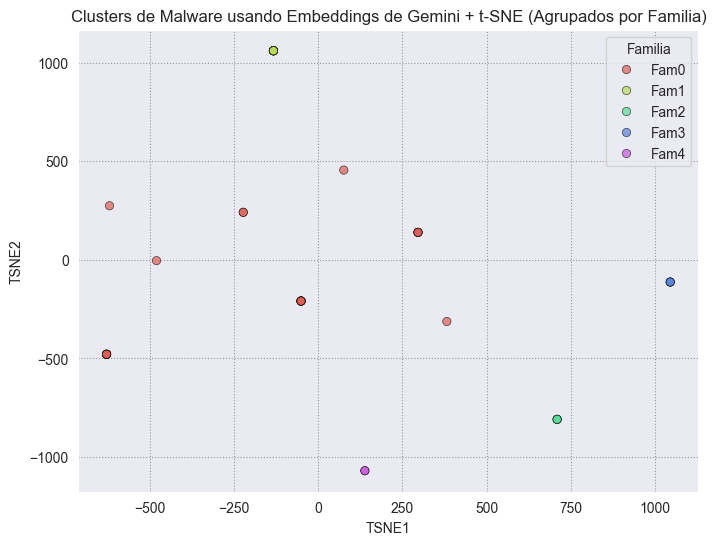

✅ Dataset con embeddings y t-SNE guardado como 'malware_families_tsne.csv'


In [30]:
# Aplicar reducción de dimensionalidad con t-SNE
tsne = TSNE(random_state=42, perplexity=5.0, n_iter=1000)
tsne_results = tsne.fit_transform(X_scaled)

# Crear DataFrame con los resultados de t-SNE
df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne["Family"] = df["Family"]

# Visualización de clusters con t-SNE
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="Family", palette="hls", edgecolor="k", alpha=0.7)
plt.title("Clusters de Malware usando Embeddings de Gemini + t-SNE (Agrupados por Familia)")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Familia", bbox_to_anchor=(1, 1))
plt.show()

# Guardar el dataset con embeddings y reducción de dimensionalidad
df_tsne.to_csv("malware_families_tsne.csv", index=False)
print("✅ Dataset con embeddings y t-SNE guardado como 'malware_families_tsne.csv'")

In [31]:
# Crear tabla con valores de t-SNE y la familia asignada
df_tsne_display = df_tsne.sample(20)  # Mostrar solo 20 filas aleatorias

# Imprimir tabla en formato bonito
import IPython.display as display
display.display(df_tsne_display)

,TSNE1,TSNE2,Family
6,709.780090,-809.476257,Fam2
34,-628.993286,-479.475739,Fam0
21,75.773201,454.963501,Fam0
19,-133.215927,1060.422241,Fam1
37,-628.993286,-479.475739,Fam0
17,382.060577,-313.089722,Fam0
28,-133.215927,1060.422241,Fam1
13,-133.215927,1060.422241,Fam1
24,296.341949,138.979355,Fam0
22,1045.798706,-112.888977,Fam3
